In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import xarray as xr

from mcs_prime import McsTracks
from mcs_prime.mcs_prime_config import PATHS
from mcs_prime import plotting as mplt

from remake import load_remake

In [2]:
tracks = McsTracks.open(PATHS['statsdir'] / 'mcs_tracks_final_extc_20190101.0000_20200101.0000.nc', 
                        PATHS['pixeldir'])
ntracks = len(tracks.dstracks.tracks)

In [3]:
tracks.dstracks

<xarray.Dataset>
Dimensions:                  (tracks: 32843, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 32839 32840 32841 32842
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] 2019-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2019-01-02T12:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Feb 28 05:50:54 2022
    startdate:                   20190101.0000
    enddate:                     20200101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [4]:
nanmask = np.isnan(tracks.dstracks.pf_landfrac.values)

In [11]:
landmask = np.nanmean(tracks.dstracks.pf_landfrac.values, axis=1) >= 0.9
ocmask = np.nanmean(tracks.dstracks.pf_landfrac.values, axis=1) < 0.1

In [12]:
landtracks = McsTracks(tracks.dstracks.isel(tracks=landmask))
octracks = McsTracks(tracks.dstracks.isel(tracks=ocmask))

In [7]:
landtracks.dstracks

<xarray.Dataset>
Dimensions:                  (tracks: 8253, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 11 12 15 18 ... 32839 32840 32842
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 20 12 10 13 11 11 20 ... 8 7 7 6 7 5
    start_status             (tracks) float64 13.0 1.0 15.0 1.0 ... 2.0 1.0 44.0
    end_status               (tracks) float64 21.0 0.0 0.0 3.0 ... 24.0 3.0 3.0
    start_basetime           (tracks) datetime64[ns] 2019-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2019-01-01T19:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... nan nan 17.0
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Feb 28 05:50:54 2022
    startdate:                   20190101.0000
    enddate:                     20200101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [14]:
octracks.dstracks

<xarray.Dataset>
Dimensions:                  (tracks: 17564, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 2 3 4 ... 32832 32834 32835 32841
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 37 17 40 12 16 9 8 ... 10 10 6 8 8 6
    start_status             (tracks) float64 13.0 13.0 15.0 ... 2.0 1.0 32.0
    end_status               (tracks) float64 37.0 0.0 3.0 34.0 ... 3.0 3.0 0.0
    start_basetime           (tracks) datetime64[ns] 2019-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2019-01-02T12:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 nan nan nan nan ... nan nan 60.0
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Mon Feb 28 05:50:54 2022
    startdate:                   20190101.0000
    enddate:                     20200101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [8]:
for thresh in [0.9, 0.95, 0.99, 1]:
    print(thresh, (np.nanmean(tracks.dstracks.pf_landfrac.values, axis=1) >= thresh).sum())

0.9 8254
0.95 7684
0.99 6881
1 5944


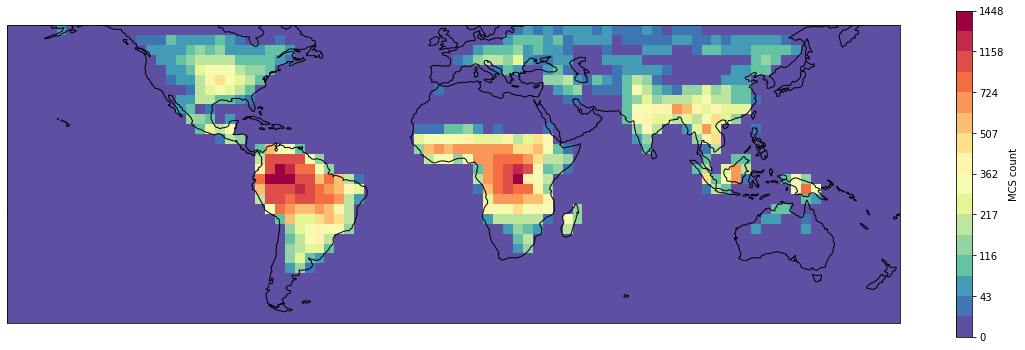

In [10]:
mplt.plot_geog_histogram(landtracks)

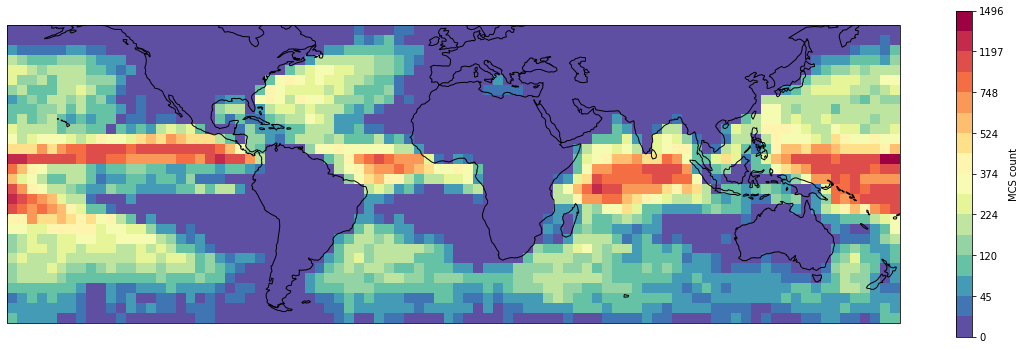

In [15]:
mplt.plot_geog_histogram(octracks)

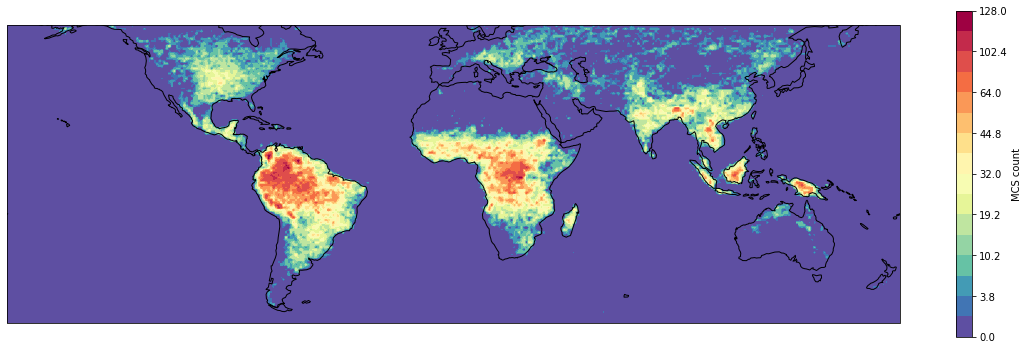

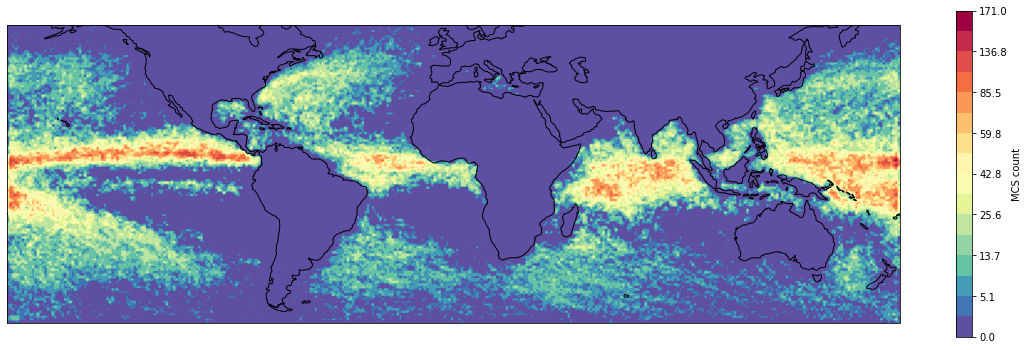

In [17]:
mplt.plot_geog_histogram(landtracks, dx=1, dy=1)
mplt.plot_geog_histogram(octracks, dx=1, dy=1)